In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, LineString, mapping, Point
import numpy as np
import itertools
import rtree
from tqdm import tqdm
pd.set_option('max_columns', None)
%matplotlib inline


street_segments = gpd.read_file("../data/processed/street_segments.geojson")
blocks = gpd.read_file("../data/processed/blocks.geojson")
buildings = gpd.read_file("../data/processed/buildings.geojson")
blockfaces = gpd.read_file("../data/processed/blockfaces.geojson")

In [50]:
def filter_on_block_id(block_id, block_id_key="geoid10"):
    def select(df):
        return (df.set_index(block_id_key)
                    .filter(like=block_id, axis='rows')
                    .reset_index()
               )
    
    return select


def get_block_data(block_id):
    ss = street_segments.pipe(filter_on_block_id(block_id))
    bf = blockfaces.pipe(filter_on_block_id(block_id))
    bldgs = buildings.pipe(filter_on_block_id(block_id))
    return ss, bf, bldgs


def plot_block(block_id):
    street_segments, blockfaces, buildings = get_block_data(block_id)
    
    ax = street_segments.plot(color='red', linewidth=1)
    blockfaces.plot(color='black', ax=ax, linewidth=1)
    buildings.plot(ax=ax, color='lightsteelblue', linewidth=1, edgecolor='steelblue')
    return ax


def simplify_linestring(inp):
    inp = inp.convex_hull
    coords = np.round(mapping(inp)['coordinates'], decimals=4)
    out = LineString(coords)
    return out
    
    
def simplify_bldg(bldg):
    if isinstance(bldg, MultiPolygon):
        bldg = bldg.buffer(0)
    
    if isinstance(bldg, MultiPolygon):
        raise NotImplemented  # TODO
    
    coords = [xyz[:2] for xyz in mapping(bldg.convex_hull)['coordinates'][0]]
    bldg = Polygon(bldg)
    
    return bldg


def pairwise_combinations(keys):
    return itertools.combinations({'a': 12, 'b': 15, 'c': 13}.keys(), r=2)


def collect_strides(point_observations):
    point_obs_keys = list(point_observations.keys())
    curr_obs_start_offset = point_obs_keys[0]
    curr_obs_start_bldg = point_observations[point_obs_keys[0]]    
    strides = dict()
    
    for point_obs in point_obs_keys[1:]:
        bldg_observed = point_observations[point_obs]
        if bldg_observed != curr_obs_start_bldg:
            strides[(curr_obs_start_offset, point_obs)] = curr_obs_start_bldg
            curr_obs_start_offset = point_obs
            curr_obs_start_bldg = bldg_observed
        else:
            continue
            
    strides[(curr_obs_start_offset, '1.00')] = bldg_observed
    
    return strides


def get_stride_boundaries(strides, step_size=0.02):
    boundaries = list()
    
    keys = list(strides.keys())
    for idx, key in enumerate(keys[1:]):
        curr = strides[key]
        boundaries.append((key[0], str(float(key[0]) + step_size)))

    return boundaries


def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= 1.0:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p), normalized=True)
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance, normalized=True)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]


def reverse(l):
    l_x, l_y = l.coords.xy
    l_x, l_y = l_x[::-1], l_y[::-1]
    return LineString(zip(l_x, l_y))

    
def chop_line_segment_using_offsets(line, offsets):
    offset_keys = list(offsets.keys())
    out = []
    
    for off_start, off_end in offset_keys:
        out_line = LineString(line.coords)
        orig_length = out_line.length
        
        # Reverse to cut off the start.
        out_line = reverse(out_line)
        out_line = cut(out_line, 1 - float(off_start))
        out_line = reverse(out_line)
        intermediate_length = out_line.length
        
        # Calculate the new cutoff end point, and apply it to the line.
        l_1_2 = (float(off_end) - float(off_start)) * orig_length
        l_1_3 = (1 - float(off_start)) * orig_length
        new_off_end = l_1_2 - l_1_3
        
        # Perform the cut.
        out_line = cut(out_line, new_off_end)
        
        if cut_result is None:
            return np.nan
        elif len(cut_result) == 1:
            out.append(cut_result[0])
        else:
            to_out, rest = cut(line, float(off_end))
            out.append(to_out)
        
    return out


def frontages_for_blockface(bldgs, blockface, step_size=0.01):
    index = rtree.Rtree()
    
    if len(bldgs) == 0:
        return gpd.GeoDataFrame()
    
    for idx, bldg in bldgs.iterrows():
        index.insert(idx, bldg.geometry.bounds)
    
    bldg_frontage_points = dict()
    
    search_space = np.arange(0, 1, step_size)
    next_search_space = []
    while len(search_space) > 0:
        for offset in search_space:
            search_point = blockface.geometry.interpolate(offset, normalized=True)
            nearest_bldg = list(index.nearest(search_point.bounds, 1))[0]
            bldg_frontage_points[str(offset)[:6]] = nearest_bldg
            
        strides = collect_strides(bldg_frontage_points)
        search_space = next_search_space
        
    # convert the list of strides to a proper GeoDataFrame
    out = []
    for sk in strides.keys():
        srs = bldgs.loc[strides[sk], ['geoid10', 'sf16_BldgID']]
        srs['geoid10_n'] = blockface['geoid10_n']
        srs['geom_offset_start'] = sk[0]
        srs['geom_offset_end'] = sk[1]
        out.append(srs)
    
    out = gpd.GeoDataFrame(out)
    
    geoms = chop_line_segment_using_offsets(blockface.geometry, strides)
    out['geometry'] = geoms

    return out

In [3]:
# model_street_segments, model_blockfaces, model_buildings = get_block_data('060759809001134')

In [4]:
# frontages_for_blockface(model_buildings, model_blockfaces.iloc[0]).plot(color=['red', 'green', 'blue'])

In [3]:
from tqdm import tqdm

In [4]:
def calculate_frontages(blocks, streets, blockfaces, buildings):
    frontages = []

    for block_idx, block in tqdm(list(blocks.iterrows())):
        _, blockfaces, buildings = get_block_data(block.geoid10)
        for blockface_idx, blockface in blockfaces.iterrows():
            result = frontages_for_blockface(buildings, blockface)
            frontages.append(result)
    
    frontages = gpd.GeoDataFrame(pd.concat(frontages)).groupby('sf16_BldgID').apply(
        lambda df: df.assign(sf16_BldgID_n=[f'{df.iloc[0].sf16_BldgID}_{n}' for n in range(len(df))])
    ).reset_index(drop=True)
    
    return frontages

In [5]:
frontages = calculate_frontages(blocks.iloc[:1000], street_segments, blockfaces, buildings)

 12%|█▏        | 121/1000 [01:53<13:43,  1.07it/s]

ValueError: Length of values does not match length of index

In [28]:
calculate_frontages(blocks.iloc[121:122], street_segments, blockfaces, buildings)


  0%|          | 0/1 [00:00<?, ?it/s]

> <ipython-input-27-22ee7cb1520b>(106)chop_line_segment_using_offsets()
-> for off_start, off_end in offset_keys:
(Pdb) offset_keys
[('0.0', '0.33'), ('0.33', '0.43'), ('0.43', '0.52'), ('0.52', '0.63'), ('0.63', '0.71'), ('0.71', '0.81'), ('0.81', '1.00')]
(Pdb) q


BdbQuit: 

In [7]:
%debug

> /Users/alex/miniconda3/envs/trash-talk/lib/python3.6/site-packages/pandas/core/series.py(4001)_sanitize_index()
   3999 
   4000     if len(data) != len(index):
-> 4001         raise ValueError('Length of values does not match length of ' 'index')
   4002 
   4003     if isinstance(data, ABCIndexClass) and not copy:

ipdb> up
> /Users/alex/miniconda3/envs/trash-talk/lib/python3.6/site-packages/pandas/core/frame.py(3391)_sanitize_column()
   3389 
   3390             # turn me into an ndarray
-> 3391             value = _sanitize_index(value, self.index, copy=False)
   3392             if not isinstance(value, (np.ndarray, Index)):
   3393                 if isinstance(value, list) and len(value) > 0:

ipdb> up
> /Users/alex/miniconda3/envs/trash-talk/lib/python3.6/site-packages/pandas/core/frame.py(3194)_set_item()
   3192 
   3193         self._ensure_valid_index(value)
-> 3194         value = self._sanitize_column(key, value)
   3195         NDFrame._set_item(self, key, value)
   3

ipdb> len(out)
41
ipdb> len(geoms)
40
ipdb> geoms
[<shapely.geometry.linestring.LineString object at 0x12a7f20b8>, <shapely.geometry.linestring.LineString object at 0x12aa57198>, <shapely.geometry.linestring.LineString object at 0x12aed60b8>, <shapely.geometry.linestring.LineString object at 0x12aed6c88>, <shapely.geometry.linestring.LineString object at 0x12aebfc50>, <shapely.geometry.linestring.LineString object at 0x12aebfe80>, <shapely.geometry.linestring.LineString object at 0x12aeaff28>, <shapely.geometry.linestring.LineString object at 0x12aeb39b0>, <shapely.geometry.linestring.LineString object at 0x12aeaf4e0>, <shapely.geometry.linestring.LineString object at 0x12a816be0>, <shapely.geometry.linestring.LineString object at 0x12aebaa90>, <shapely.geometry.linestring.LineString object at 0x12aebad30>, <shapely.geometry.linestring.LineString object at 0x12aa940f0>, <shapely.geometry.linestring.LineString object at 0x12aa59278>, <shapely.geometry.linestring.LineString object at 0x1

In [16]:
d = gpd.read_file("temp.geojson").set_index('id')

In [19]:
d.geometry.map(lambda shp: shp.length)

id
0     1.915595e-04
1     2.911704e-04
2     3.683306e-04
3     3.874168e-04
4     3.629798e-04
5     3.344599e-04
6     3.221964e-04
7     2.831538e-04
8     2.708838e-04
9     2.445693e-04
10    2.013621e-04
11    1.662012e-04
12    1.220719e-04
13    9.114702e-05
14    6.779059e-05
15    4.532285e-05
16    3.061811e-05
17    1.998234e-05
18    1.258888e-05
19    7.823087e-06
20    4.493929e-06
21    2.533811e-06
22    1.317582e-06
23    6.567638e-07
24    3.133007e-07
25    1.427756e-07
26    6.410132e-08
27    2.475138e-08
28    9.448742e-09
29    3.408813e-09
30    1.158489e-09
31    3.695422e-10
32    1.116932e-10
33    2.982504e-11
34    7.345692e-12
35    1.658048e-12
36    3.317557e-13
37    6.550880e-14
38    1.588822e-14
39    0.000000e+00
Name: geometry, dtype: float64

In [23]:
from shapely.geometry import LineString
s, e = cut(LineString(((0, 0), (0, 5))), 0.5)

In [25]:
mapping(s)

{'type': 'LineString', 'coordinates': ((0.0, 0.0), (0.0, 2.5))}

In [26]:
mapping(e)

{'type': 'LineString', 'coordinates': ((0.0, 2.5), (0.0, 5.0))}

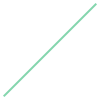

In [49]:
l

In [47]:
l = LineString(((0, 0), (1, 1)))
mapping(reverse(l))

{'type': 'LineString', 'coordinates': ((0.0, 0.0), (1.0, 1.0))}

TODO: check frontages for consistency.